# Vision Transformer (ViT) on CIFAR-10 — Colab Notebook

> **Goal**: Implement and train a Vision Transformer (from scratch) on CIFAR-10 and reach strong test accuracy.
>
> **Implements**: Patchify, learnable positional embeddings, [CLS] token, transformer encoder blocks (MHSA + MLP, pre-norm, residual), classifier head from [CLS].
>
> **Paper**: *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale* (Dosovitskiy et al., ICLR 2021).

**How to use (Colab):** Runtime → Change runtime type → **T4/A100 GPU**, then **Run all**. Tune the config in the next cell if needed.

In [3]:
#@title Environment & versions
import torch, torchvision
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Device count:', torch.cuda.device_count())
print('CUDA device:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')

PyTorch: 2.6.0+cu124
Torchvision: 0.21.0+cu124
CUDA available: True
Device count: 2
CUDA device: Tesla T4


In [18]:
# Config (replace your Cell 2)
from dataclasses import dataclass

@dataclass
class CFG:
    # Data
    dataset: str = "CIFAR10"
    data_root: str = "./data"
    num_classes: int = 10
    img_size: int = 48          # upsample CIFAR-10 → helps ViT a lot
    patch_size: int = 4         # non-overlapping patches as required
    # Model (bigger & stronger)
    embed_dim: int = 512
    depth: int = 8
    num_heads: int = 8
    mlp_ratio: float = 4.0
    qkv_bias: bool = True
    drop_rate: float = 0.1
    attn_drop_rate: float = 0.0
    drop_path_rate: float = 0.2  # more stochastic depth
    # Optim & schedule
    epochs: int = 200           # longer horizon
    batch_size: int = 128       # lower if OOM; 64 still fine
    base_lr: float = 5e-4
    min_lr: float = 5e-6
    weight_decay: float = 0.05
    warmup_epochs: int = 10
    # Tricks
    label_smoothing: float = 0.1
    mixup_alpha: float = 0.4     # stronger mixup
    cutmix_alpha: float = 1.0     # enable CutMix alongside MixUp
    random_erasing_p: float = 0.25
    # Training niceties
    amp: bool = True
    compile: bool = True
    ema_decay: float = 0.999     # Exponential Moving Average of weights
    grad_accum_steps: int = 1    # set >1 if you need a bigger effective batch
    out_dir: str = "./outputs"

cfg = CFG()
cfg.num_workers = 4
cfg


CFG(dataset='CIFAR10', data_root='./data', num_classes=10, img_size=48, patch_size=4, embed_dim=512, depth=8, num_heads=8, mlp_ratio=4.0, qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.0, drop_path_rate=0.2, epochs=200, batch_size=128, base_lr=0.0005, min_lr=5e-06, weight_decay=0.05, warmup_epochs=10, label_smoothing=0.1, mixup_alpha=0.4, cutmix_alpha=1.0, random_erasing_p=0.25, amp=True, compile=True, ema_decay=0.999, grad_accum_steps=1, out_dir='./outputs')

In [19]:
#@title Utilities: seeding, metrics, LR schedule
import math, random, os, time
import numpy as np
import torch
from torch import nn

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k * (100.0 / batch_size)).item())
        return res

class WarmupCosineLR:
    def __init__(self, optimizer, warmup_steps, total_steps, base_lr, min_lr):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.base_lr = base_lr
        self.min_lr = min_lr
        self.last_step = 0

    def step(self):
        self.last_step += 1
        if self.last_step < self.warmup_steps:
            lr = self.base_lr * self.last_step / max(1, self.warmup_steps)
        else:
            progress = (self.last_step - self.warmup_steps) / max(1, self.total_steps - self.warmup_steps)
            lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) * (1 + math.cos(math.pi * progress))
        for pg in self.optimizer.param_groups:
            pg["lr"] = lr
        return lr

In [20]:
# Cell 0 — CIFAR-10 fetch with robust fallbacks (mirror → manual upload)
import os, tarfile, urllib.request, io
from pathlib import Path

data_root = Path(getattr(cfg, "data_root", "./data"))
data_root.mkdir(parents=True, exist_ok=True)
archive_path = data_root / "cifar-10-python.tar.gz"
target_dir = data_root / "cifar-10-batches-py"

if target_dir.exists():
    print("✅ CIFAR-10 already present at", target_dir)
else:
    urls = [
        "https://ossci-datasets.s3.amazonaws.com/cifar-10-python.tar.gz",
        "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
    ]
    downloaded = False
    for url in urls:
        try:
            print(f"Trying mirror: {url}")
            urllib.request.urlretrieve(url, archive_path)
            downloaded = True
            print("Downloaded:", archive_path)
            break
        except Exception as e:
            print("Download failed from this mirror:", e)

    if not downloaded:
        print("\n🌐 Network looks down or DNS failing. We'll switch to MANUAL upload.")
        try:
            from google.colab import files  # Only exists on Colab
            print("👉 Please upload a file named: cifar-10-python.tar.gz")
            uploaded = files.upload()  # pick the tar.gz from your computer
            if "cifar-10-python.tar.gz" not in uploaded:
                raise RuntimeError("You must upload 'cifar-10-python.tar.gz'")
            with open(archive_path, "wb") as f:
                f.write(uploaded["cifar-10-python.tar.gz"])
            downloaded = True
        except Exception as e:
            raise RuntimeError("Manual upload failed. Error: " + str(e))

    # Extract
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=data_root)
    print("📦 Extracted to:", target_dir)
    try:
        os.remove(archive_path)
    except Exception:
        pass


Trying mirror: https://ossci-datasets.s3.amazonaws.com/cifar-10-python.tar.gz


KeyboardInterrupt: 

In [27]:
# Data: use Kaggle's built-in CIFAR-10 dataset (already available)
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import os

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# Kaggle input path
cfg.data_root = "/kaggle/input/cifar-10"

# Use strong augments if you're targeting 90%+
try:
    RA = transforms.RandAugment(num_ops=2, magnitude=12)
except Exception:
    RA = transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10)

train_transform = transforms.Compose([
    transforms.Resize(cfg.img_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(cfg.img_size, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    RA,
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    transforms.RandomErasing(p=getattr(cfg, "random_erasing_p", 0.25),
                             scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])

test_transform = transforms.Compose([
    transforms.Resize(cfg.img_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Load from Kaggle folder (no download needed)
train_set = torchvision.datasets.CIFAR10(root=cfg.data_root, train=True, download=False, transform=train_transform)
test_set  = torchvision.datasets.CIFAR10(root=cfg.data_root, train=False, download=False, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_set, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

print(f"✅ Loaded CIFAR-10 from {cfg.data_root}")
print("Train size:", len(train_set), "| Test size:", len(test_set))


✅ Loaded CIFAR-10 from /kaggle/input/cifar-10
Train size: 50000 | Test size: 10000


In [28]:
# MixUp + CutMix helpers (replace your Cell 5)
import torch, numpy as np

def _rand_bbox(size, lam):
    """Generate CutMix bbox."""
    W, H = size[-1], size[-2]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, y1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    x2, y2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def mixup_cutmix(images, targets, mixup_alpha=0.4, cutmix_alpha=1.0, p_cutmix=0.5):
    """Randomly apply MixUp or CutMix; return mixed images and (ya, yb, lam)."""
    if mixup_alpha <= 0 and cutmix_alpha <= 0:
        return images, targets, targets, 1.0

    use_cutmix = (cutmix_alpha > 0) and (np.random.rand() < p_cutmix)
    if use_cutmix:
        lam = np.random.beta(cutmix_alpha, cutmix_alpha)
        idx = torch.randperm(images.size(0), device=images.device)
        x1, y1, x2, y2 = _rand_bbox(images.size(), lam)
        images[:, :, y1:y2, x1:x2] = images[idx, :, y1:y2, x1:x2]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (images.size(-1) * images.size(-2)))
        y_a, y_b = targets, targets[idx]
        return images, y_a, y_b, lam
    else:
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        idx = torch.randperm(images.size(0), device=images.device)
        mixed = lam * images + (1 - lam) * images[idx]
        return mixed, targets, targets[idx], lam

def mix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [29]:
# Add this as a NEW cell after Cell 6 (model) and before training
class ModelEMA:
    """Exponential Moving Average of model weights."""
    def __init__(self, model, decay=0.999):
        import copy
        self.ema = copy.deepcopy(model).eval()
        self.decay = decay
        for p in self.ema.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update(self, model):
        d = self.decay
        msd = model.state_dict()
        for k, v in self.ema.state_dict().items():
            if v.dtype.is_floating_point:
                v.copy_(v * d + msd[k] * (1. - d))


In [30]:
#@title ViT implementation (from scratch)
import torch
from torch import nn

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
        output = x.div(keep_prob) * random_tensor
        return output

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, v = qkv[0], qkv[2]
        k = qkv[1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class PatchEmbed(nn.Module):
    """Image to Patch Embedding using Conv2d."""
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=384):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # B, C, H, W -> B, embed_dim, H/ps, W/ps -> B, N, embed_dim
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=384, depth=6, num_heads=6, mlp_ratio=4.0, qkv_bias=True,
                 drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = embed_dim
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i])
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, N, C)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, C)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1+N, C)
        x = x + self.pos_embed  # broadcast add
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls = x[:, 0]
        return self.head(cls)

In [33]:
#@title Train & evaluate
import torch, time, os
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs(cfg.out_dir, exist_ok=True)

model = ViT(img_size=cfg.img_size,
            patch_size=cfg.patch_size,
            in_chans=3,
            num_classes=cfg.num_classes,
            embed_dim=cfg.embed_dim,
            depth=cfg.depth,
            num_heads=cfg.num_heads,
            mlp_ratio=cfg.mlp_ratio,
            qkv_bias=cfg.qkv_bias,
            drop_rate=cfg.drop_rate,
            attn_drop_rate=cfg.attn_drop_rate,
            drop_path_rate=cfg.drop_path_rate)

if cfg.compile and hasattr(torch, 'compile'):
    try:
        model = torch.compile(model)
        print('Model compiled with torch.compile')
    except Exception as e:
        print('torch.compile failed, continuing without:', e)

model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.base_lr, weight_decay=cfg.weight_decay)

total_steps = cfg.epochs * len(train_loader)
warmup_steps = int(cfg.warmup_epochs * len(train_loader))
scheduler = WarmupCosineLR(optimizer, warmup_steps, total_steps, cfg.base_lr, cfg.min_lr)

scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)

best_acc = 0.0
history = {"train_loss": [], "train_acc": [], "test_acc": []}
start_time = time.time()

for epoch in range(1, cfg.epochs + 1):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n_samples = 0

    for images, targets in train_loader:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        # Mixup (optional)
        images, y_a, y_b, lam = mixup_cutmix(
            images, targets,
            mixup_alpha=cfg.mixup_alpha,
            cutmix_alpha=cfg.cutmix_alpha,
            p_cutmix=0.5
        )

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            outputs = model(images)
            loss = mix_criterion(criterion, outputs, y_a, y_b, lam)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr = scheduler.step()

        # For display, compute "nominal" top1 acc against hard labels (y_a) — approximate when mixup is on
        top1 = accuracy(outputs, y_a, topk=(1,))[0]

        bs = images.size(0)
        running_loss += loss.item() * bs
        running_acc  += top1 * bs
        n_samples    += bs

    train_loss = running_loss / n_samples
    train_acc = running_acc / n_samples

    # Eval
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=cfg.amp):
                outputs = model(images)
            pred = outputs.argmax(dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)
    test_acc = 100.0 * correct / total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({"model": model.state_dict(), "cfg": asdict(cfg), "best_acc": best_acc},
                   os.path.join(cfg.out_dir, "best_vit_cifar10.pth"))

    print(f"Epoch {epoch:03d}/{cfg.epochs} | lr={optimizer.param_groups[0]['lr']:.2e} | "
          f"loss={train_loss:.4f} | train@1={train_acc:.2f}% | test@1={test_acc:.2f}% | best={best_acc:.2f}%")

elapsed = (time.time() - start_time)/60
print(f"Training done in {elapsed:.1f} min. Best test@1: {best_acc:.2f}%")

Model compiled with torch.compile


/tmp/ipykernel_36/1065241481.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)
/tmp/ipykernel_36/1065241481.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):
/tmp/ipykernel_36/1065241481.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):
/tmp/ipykernel_36/1065241481.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):


Epoch 001/200 | lr=5.00e-05 | loss=2.2791 | train@1=16.56% | test@1=31.32% | best=31.32%


/tmp/ipykernel_36/1065241481.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):
/tmp/ipykernel_36/1065241481.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):


Epoch 002/200 | lr=1.00e-04 | loss=2.1208 | train@1=20.35% | test@1=36.57% | best=36.57%
Epoch 003/200 | lr=1.50e-04 | loss=2.0612 | train@1=24.35% | test@1=46.47% | best=46.47%
Epoch 004/200 | lr=2.00e-04 | loss=2.0084 | train@1=27.28% | test@1=49.07% | best=49.07%
Epoch 005/200 | lr=2.50e-04 | loss=1.9889 | train@1=28.10% | test@1=50.79% | best=50.79%
Epoch 006/200 | lr=3.00e-04 | loss=1.9760 | train@1=28.13% | test@1=51.82% | best=51.82%
Epoch 007/200 | lr=3.50e-04 | loss=1.9729 | train@1=28.86% | test@1=50.29% | best=51.82%
Epoch 008/200 | lr=4.00e-04 | loss=1.9494 | train@1=29.85% | test@1=53.99% | best=53.99%
Epoch 009/200 | lr=4.50e-04 | loss=1.9448 | train@1=29.95% | test@1=51.83% | best=53.99%
Epoch 010/200 | lr=5.00e-04 | loss=1.9470 | train@1=30.06% | test@1=53.60% | best=53.99%
Epoch 011/200 | lr=5.00e-04 | loss=1.9420 | train@1=30.10% | test@1=54.02% | best=54.02%
Epoch 012/200 | lr=5.00e-04 | loss=1.9189 | train@1=29.87% | test@1=54.85% | best=54.85%
Epoch 013/200 | lr=5.

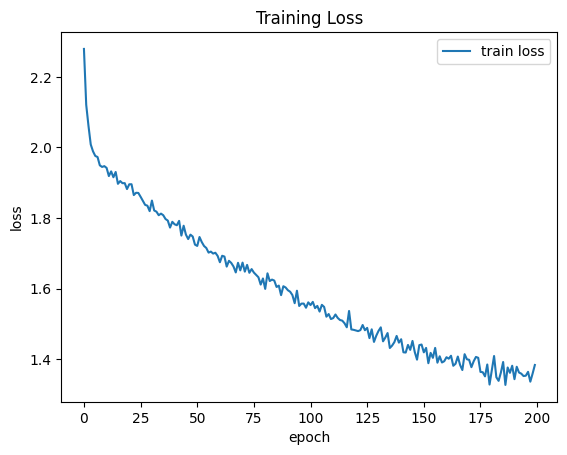

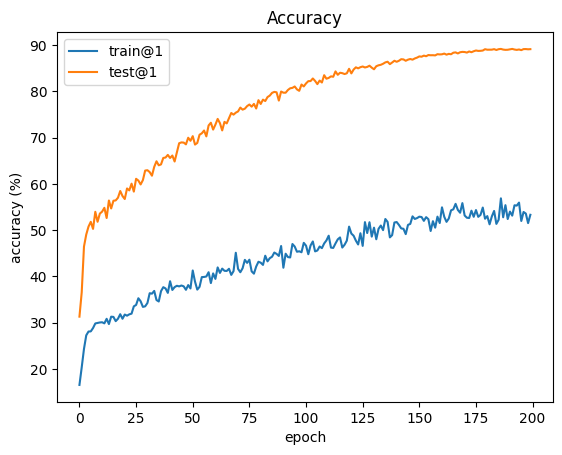

In [34]:
#@title Plot training curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Training Loss")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train@1")
plt.plot(history["test_acc"], label="test@1")
plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.legend(); plt.title("Accuracy")
plt.show()

/tmp/ipykernel_36/2456198474.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):


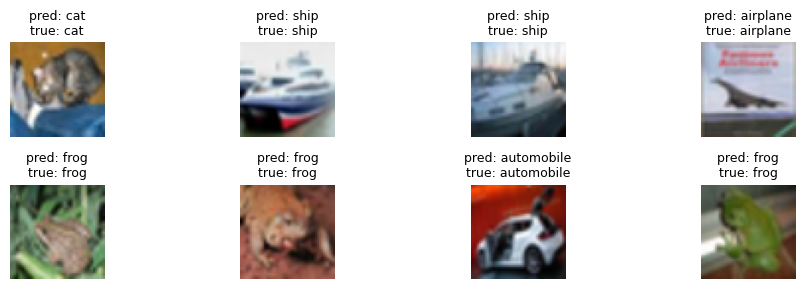

In [35]:
#@title Inference demo: show a few predictions
import torch, torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

classes = train_set.classes

model.eval()
images, labels = next(iter(test_loader))
images = images[:8].to(device)
labels = labels[:8].to(device)
with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=cfg.amp):
        logits = model(images)
pred = logits.argmax(dim=1)

inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))],
    std=[1/s for s in (0.2470, 0.2435, 0.2616)]
)

import numpy as np
plt.figure(figsize=(10, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = inv_norm(images[i].cpu()).clamp(0,1).permute(1,2,0).numpy()
    plt.imshow(img)
    ttl = f"pred: {classes[pred[i]]}\ntrue: {classes[labels[i]]}"
    plt.title(ttl, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [36]:
#@title Save run summary (config + best accuracy)
import json, os
from dataclasses import asdict
summary = {"best_test_acc": max(history["test_acc"]) if history["test_acc"] else None,
           "config": asdict(cfg)}
os.makedirs(cfg.out_dir, exist_ok=True)
with open(os.path.join(cfg.out_dir, "run_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)
print(summary)

{'best_test_acc': 89.2, 'config': {'dataset': 'CIFAR10', 'data_root': '/kaggle/input/cifar-10', 'num_classes': 10, 'img_size': 48, 'patch_size': 4, 'embed_dim': 512, 'depth': 8, 'num_heads': 8, 'mlp_ratio': 4.0, 'qkv_bias': True, 'drop_rate': 0.1, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.2, 'epochs': 200, 'batch_size': 128, 'base_lr': 0.0005, 'min_lr': 5e-06, 'weight_decay': 0.05, 'warmup_epochs': 10, 'label_smoothing': 0.1, 'mixup_alpha': 0.4, 'cutmix_alpha': 1.0, 'random_erasing_p': 0.25, 'amp': True, 'compile': True, 'ema_decay': 0.999, 'grad_accum_steps': 1, 'out_dir': './outputs'}}
